## **Part A: BoP on time series data**

In this assignment we will build a k Nearest Neighbor Classsifier on gun point time series data. This dataset involves one female actor and one male actor making a motion with their hand. The two classes are: Gun-Draw and Point: For Gun-Draw the actors have their hands by their sides. For Point the actors have their gun by their sides.

You are a senior data scientist in a security firm and your job is to build a model to classify suspicious hand gestures activities using a data-driven approach either as:

Gun Point class
Gun Draw class


**Question 0:** Upload the 'GUN_DATA.csv' under the sample_data folder and importing all the package that we need in this homework. (Do not forget to run every code block)

In [1]:
# Import needed libraries
!pip install pyts
import numpy as np
import matplotlib.pyplot as plt
from pyts.transformation import BagOfPatterns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import seaborn as sns; sns.set_theme()
#I'm also going to use the following:
import string
import itertools

Now let's add the data file in the sample_data folder of the Files tab (in the left corner)

We will then read the CSV data that we just uploaded from the python script

In [2]:
# Read the data file and print it
data =  pd.read_csv("sample_data/GUN_DATA (2).csv")
Y = data.iloc[:,-1:]
data = data.iloc[: , :-1]

data = np.array(data)
Y = np.array(Y)

# This function returns the dataset splitted into train and test 
def getSplit(Xdata, Y):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=19)
  sss.get_n_splits(Xdata, Y)
  for train_index, test_index in sss.split(Xdata, Y):
      X_train, X_test = Xdata[train_index], Xdata[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
  return X_train, y_train, X_test, y_test



**Question 1:** Based on the BoP representation example below, define a utility function that takes three parameters:
, word_len, and X_data) and returns the BoP representation of the data

*   alpha_size:alphabet size
*   word_len: word length of the BoP representation
*   X_data: the input data to be transformed



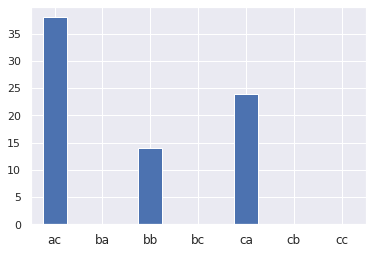

In [3]:
# Bag-of-patterns representation for time series of alphabet size (n_bins), an wprd length (word_size)
bop = BagOfPatterns(window_size=0.5, word_size=2, n_bins=3,
                    numerosity_reduction=False, sparse=False)

# returns the BoP Representation vector with respect to each word
X_data_bop = bop.fit_transform(data)
pd.DataFrame(X_data_bop).iloc[0].plot.bar(rot=0)

plt.xticks(np.arange(len(bop.vocabulary_)),
           np.vectorize(bop.vocabulary_.get)(np.arange(X_data_bop[0].size)),
           fontsize=12)
plt.show()


In [4]:
def get_BOP_transform(alpha_size, word_len, X_data):
    # INSERT CODE HERE
    alphabet = string.ascii_lowercase[:alpha_size]
    #vecDim = alpha_size**word_len #written in terms of the word length and alphabet size.
    #let's chunk up the range of the data so that we can bin points into words.
    #Min = np.amin(X_data)   #It may have been a mistake to compute this for the whole dataset.
    #Max = np.amax(X_data)   #Let's try this on a per time series basis.
    #deltaX = (Max-Min)/alpha_size
    #endpoints = [Min + i*deltaX for i in range(alpha_size)]
    #print(endpoints)
    
    def getWords(alphabet,word_len): #this will list all possible words based on our alphabet and wordlength.
        mydic = {}
        for item in itertools.product(alphabet, repeat=word_len): #I ripped this line off the internet...
            string = "".join(item)
            if string not in mydic:
                mydic[string] = 0
        return mydic
    
    def ptToAlpha(p,endpoints,alphabet): #this will convert a point into a letter in our alphabet.
        #first we get which bin it's in
        pkey = endpoints[0]
        lkey = endpoints[-1]
        for i in range(1,len(endpoints)):
            nkey = endpoints[i]
            if p>=pkey and p<nkey:
                return alphabet[i-1]
                return
            pkey = endpoints[i]
        return alphabet[-1]
        
        
    #def getLetters(x,endpoints,alphabet): #this converts a list of points into a single string of our letters.
    def getLetters(x,alphabet):
        #Try computing endpoints here instead of earlier.
        Min = min(x)
        Max = max(x)
        deltaX = (Max-Min)/alpha_size
        endpoints = [Min + i*deltaX for i in range(alpha_size)]
        newx = []
        for p in x:
            letter = ptToAlpha(p,endpoints,alphabet)
            newx.extend([letter])
        newx2 = ''.join(newx)
        return newx2
    
    def extractWords(String,word_len,dic): #this will count the number of times the given words appear in the string
        start = 0
        end = word_len-1
        L = len(String)
        while end < L:
            word = String[start:end+1]
            dic[word] += 1
            start += 1
            end += 1
        return dic
        
    data_BOP = []
    #Words = getWords(alphabet,word_len) #here are all possible words.
    for x in X_data: #Turn every datapoint into a histogram.
        #xp = getLetters(x,endpoints,alphabet)
        xp = getLetters(x,alphabet)
        Words = getWords(alphabet,word_len)
        xp = extractWords(xp,word_len,Words)
        xp = [xp[key] for key in xp]
        data_BOP.extend([xp])
        
    data_BOP = np.array(data_BOP)
    return data_BOP

**Question 2:** Define a function that takes four parameters:
(X_trainBOP, y_train, X_testBOP, y_test), trains a random forest classifier (with 100 decision trees) and returns the test accuracy of the model.

In [5]:
def get_RandomForest_accuracy(X_trainBOP, y_train, X_testBOP, y_test, trees=100, TrainAcc=False):
    clf = RandomForestClassifier(n_estimators=trees,random_state=42)
    # INSERT CODE HERE
    #reshape y
    ytr = y_train.reshape([y_train.shape[0],])
    yte = y_test.reshape([y_test.shape[0],])
    clf.fit(X_trainBOP,ytr)
    accuracy = clf.score(X_testBOP,yte)
    if TrainAcc == True:
        Tacc = clf.score(X_trainBOP, ytr)
        return np.array([accuracy, Tacc])
    return accuracy

**Question 3:** Define a grid search function that takes four inputs(alpha_min, alpha_max, wordlen_min, wordlen_max) and returns a matrix of test accuracies.

Hint: you can use the get_BOP_transform, getSplit and get_RandomForest_accuracy

In [6]:
def get_gridsearch(alpha_min, alpha_max, wordlen_min, wordlen_max):
    accuracy_matrix = []
    alphalist = [alpha for alpha in range(alpha_min, alpha_max)]
    wordlenlist = [wl for wl in range(wordlen_min, wordlen_max)]
    #for alpha in range(alpha_min, alpha_max):
    for alpha in alphalist:
        scores = []
        #for wordlen in range(wordlen_min, wordlen_max):
        for wordlen in wordlenlist:
            # INSERT CODE HERE
            BOPrep = get_BOP_transform(alpha, wordlen, data)
            Xtrain, ytrain, Xtest, ytest = getSplit(BOPrep,Y)
            score = get_RandomForest_accuracy(Xtrain,ytrain,Xtest,ytest)
            scores.extend([score])
        
        accuracy_matrix.extend([scores])
        
    #Here are the indices of the best:
    Am = np.array(accuracy_matrix)
    inds = np.unravel_index(np.argmax(Am),Am.shape)
    params = [alphalist[inds[0]],wordlenlist[inds[1]]]
    return accuracy_matrix, params

Best number of letters: 5
Best word length: 3


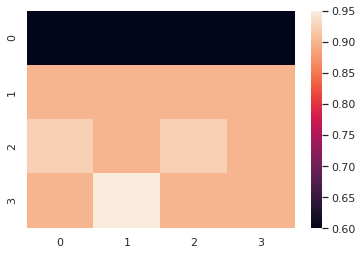

In [7]:
# The following heatmap shows a vizualization of the 2 grid search parameters 
gridparam, bests = get_gridsearch(2, 6, 2, 6)
print("Best number of letters: " + str(bests[0]))
print("Best word length: " + str(bests[1]))
sns.heatmap(gridparam)
plt.show()

### **PART B: CS 6890 -  GRADUATE STUDENTS ONLY:**

**Question 4:**
1. Find the BoP representation using the best set of parameters found in **Part A** and train a random forest classifier with numbers of decision tress ranging from 1 to 20. 

2. Record the training and testing accuracies for each model and finally draw the learning curve.


In [8]:
test_accuracies = []
train_accuracies = []

X_bop = get_BOP_transform(bests[0], bests[1], data) #the above code was slightly modified so that "bests" is
                                                      #a list of the best parameters. They are also printed
                                                      # above the heatmap, for reference.
X_train_bop, y_train, X_test_bop, y_test = getSplit(X_bop, Y)

for decision_trees in range(1,20,1):
    #INSERT CODE HERE
    accs = get_RandomForest_accuracy(X_train_bop, y_train, X_test_bop, y_test, 
                                        trees=decision_trees, TrainAcc=True) #the command was modified to make this 
                                                                              #part easier.
    accsT = accs.transpose()
    test_accuracies.extend([accsT[0]])
    train_accuracies.extend([accsT[1]])

**Question 6:** Draw the learning curve of the random forest classifier for training and testing accuracies as the number of decision trees is increasing.



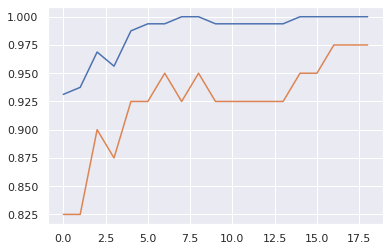

In [9]:
# INSERT CODE HERE
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.show()